In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

from admm_approximate_solver import Approximate_ReLU_ADMM_Solver
from relu_utils import squared_loss, classifcation_accuracy

In [2]:
# generate toy data trying to fit noisy data to cosine
data = pd.read_csv("test_data/winequality-red.csv", delimiter=";")
X = np.array(data)[:,:11]
y = np.array(data.quality)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_train, d = X_train.shape
n_test = X_test.shape[0]

print(f"n train = {n_train}")
print(f"n test = {n_test}")

m = 10

n train = 1279
n test = 320


NONCONVEX PROBLEM WEIGHTS:
Train loss: 436.50000000000006
Train accuracy: 0.5152462861610634
Test loss: 114.0
Test accuracy: 0.496875


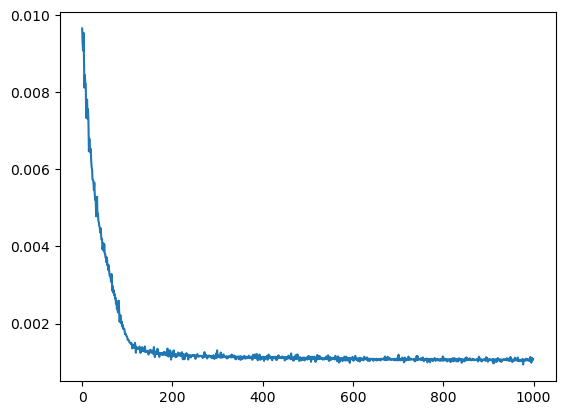

In [3]:
# TODO still need to optimize lr and batch_size

# Try to use GPU 
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training params
lr = 1e-3
batch_size = 2 ** 10
epochs = 500

# Network
MLP = nn.Sequential(nn.Linear(d, m),
                    nn.ReLU(),
                    nn.Linear(m, np.max(y)+1)).to(dev)

# Train/Test data to torch
X_train_torch = torch.as_tensor(X_train, dtype=torch.float32)
y_train_torch = torch.as_tensor(y_train, dtype=torch.float32)
X_test_torch = torch.as_tensor(X_test, dtype=torch.float32)
y_test_torch = torch.as_tensor(y_test, dtype=torch.float32)
trainset = TensorDataset(X_train_torch, y_train_torch)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Optimizer and loss
optim = torch.optim.Adam(MLP.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

# Train
losses = []
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}', end='\r', flush=True)
    for sample, label in iter(trainloader):

        # Move to device
        sample = sample.to(dev)
        label = label.to(dev)

        # predict 
        pred = MLP(sample)

        # Back prop
        loss = loss_func(pred, label.long())
        loss.backward()
        optim.step()
        optim.zero_grad()
        losses.append(float(loss) / batch_size)

# Show trianing curve 
plt.plot(losses)

# Prediction
with torch.no_grad():
    y_hat_train = np.argmax(MLP(X_train_torch.to(dev)).to('cpu').numpy(), axis=-1)
    y_hat_test = np.argmax(MLP(X_test_torch.to(dev)).to('cpu').numpy(), axis=-1)

# Show results
print("NONCONVEX PROBLEM WEIGHTS:")
print(f"Train loss: {squared_loss(y_hat_train, y_train)}")
print(f"Train accuracy: {classifcation_accuracy(y_hat_train, y_train)}")
print(f"Test loss: {squared_loss(y_hat_test, y_test)}")
print(f"Test accuracy: {classifcation_accuracy(y_hat_test, y_test)}")

Solver doesn't converge well... Things needing fixing right now: 

- How to choose m, P_S?
- How to choose parameters $\rho$, step=$\gamma_{\alpha}$, $\beta$? 
- Converting from optimal weights $v, w$ to $u, \alpha$. Currently loss during training is consistently high but gets lower when calling .predict
- Runtime warning - divide by zero in optimizer. need to figure out why / fix

In [4]:
# solve cvx problem

solver = Approximate_ReLU_ADMM_Solver(m=10,
                                      P_S=10,
                                      rho=0.0001,
                                      step=0.00001,
                                      beta=0.0001,
                                      bias=True,
                                      loss_func=squared_loss,
                                      acc_func=classifcation_accuracy)

solver.optimize(X_train, y_train, max_iter=100, verbose=True)


print("CONVEX PROBLEM WEIGHTS:")
y_hat_train = solver.predict(X_train, weights="C-ReLU")
y_hat_test = solver.predict(X_test, weights="C-ReLU")
print(f"Train loss: {squared_loss(y_hat_train, y_train)}")
print(f"Train accuracy: {classifcation_accuracy(y_hat_train, y_train)}")
print(f"Test loss: {squared_loss(y_hat_test, y_test)}")
print(f"Test accuracy: {classifcation_accuracy(y_hat_test, y_test)}")


# print("NONCONVEX PROBLEM WEIGHTS:")
# y_hat_train = solver.predict(X_train, weights="NC-ReLU")
# y_hat_test = solver.predict(X_test, weights="NC-ReLU")
# print(f"Train loss: {squared_loss(y_hat_train, y_train)}")
# print(f"Train accuracy: {classifcation_accuracy(y_hat_train, y_train)}")
# print(f"Test loss: {squared_loss(y_hat_test, y_test)}")
# print(f"Test accuracy: {classifcation_accuracy(y_hat_test, y_test)}")

iter = 0, loss = 20642.500000000004, acc = 0.0
iter = 1, loss = 234.14209462706344, acc = 0.6434714620797498
iter = 2, loss = 233.7428496235691, acc = 0.6411258795934324
iter = 3, loss = 233.54263416504088, acc = 0.6426896012509773
iter = 4, loss = 233.4186265754227, acc = 0.6450351837372947
iter = 5, loss = 233.3383729146086, acc = 0.6450351837372947
iter = 6, loss = 233.28386681049088, acc = 0.6442533229085223
iter = 7, loss = 233.24591206589278, acc = 0.6442533229085223
iter = 8, loss = 233.21886882492248, acc = 0.6434714620797498
iter = 9, loss = 233.19916403086378, acc = 0.6434714620797498
iter = 10, loss = 233.18448326403407, acc = 0.6426896012509773
iter = 11, loss = 233.1732924310456, acc = 0.6426896012509773
iter = 12, loss = 233.1645596985371, acc = 0.6426896012509773
iter = 13, loss = 233.15758027591195, acc = 0.6426896012509773
iter = 14, loss = 233.15186773259813, acc = 0.6434714620797498
iter = 15, loss = 233.14708280931777, acc = 0.6434714620797498
iter = 16, loss = 233.

/home/daniel/devel/baADMM/admm_approximate_solver.py:191: RuntimeWarning: divide by zero encountered in scalar divide
  v[inds] = np.maximum(1 - self.beta/(self.rho * LA.norm(u[inds] + lam[inds])), 0) * (u[inds] + lam[inds])


iter = 50, loss = 233.08397722095398, acc = 0.6442533229085223
iter = 51, loss = 233.08287484425873, acc = 0.6442533229085223
iter = 52, loss = 233.08179160574193, acc = 0.6442533229085223
iter = 53, loss = 233.08072720975784, acc = 0.6442533229085223
iter = 54, loss = 233.07968135812993, acc = 0.6442533229085223
iter = 55, loss = 233.07865362430363, acc = 0.6442533229085223
iter = 56, loss = 233.07764382428573, acc = 0.6442533229085223
iter = 57, loss = 233.0766516205044, acc = 0.6442533229085223
iter = 58, loss = 233.07567663765926, acc = 0.6442533229085223
iter = 59, loss = 233.074718577715, acc = 0.6442533229085223
iter = 60, loss = 233.073777139938, acc = 0.6442533229085223
iter = 61, loss = 233.07285203754495, acc = 0.6442533229085223
iter = 62, loss = 233.0719430423416, acc = 0.6442533229085223
iter = 63, loss = 233.07104990244446, acc = 0.6442533229085223
iter = 64, loss = 233.07017250089135, acc = 0.6442533229085223
iter = 65, loss = 233.06931054566022, acc = 0.644253322908522